#План работы



1. Изучение первичных данных
2. Предобработка данных(типы данных, столбцы)
3. Анализ данных, построение графиков по времени и используемым ресурсам
4. Поиск аномалий и удаление ненужной/некорректной информации или заполнение пустых значений
5. Создание общей выборки для деления на тестовую, валидационную и обучающую
6. Подбор гиперпараметров модели и выбор наилучшей
7. Тест модели

Для оптимизитрования расхода электричества требуется построить модель для предсказания оптимальной температуры на производстве.

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

<a id = Pred></a>
#Подготовка данных

<a id = Res></a>
##Изучение файлов

In [82]:
!pip3 install catboost

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
RANDOM_STATE = 240423

In [84]:
arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [85]:
data_list = [arc, bulk, bulk_time, gas, temp, wire, wire_time]

In [86]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [87]:
def about(data):
    print(data.info())
    print('-'*100)
    display(data.head(15))
    print('-'*100)
    print(data.describe())

In [88]:
about(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------------------------------------------------------------------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


----------------------------------------------------------------------------------------------------
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284


In [89]:
about(bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
----------------------------------------------------------------------------------------------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


----------------------------------------------------------------------------------------------------
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646  

In [90]:
about(bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
----------------------------------------------------------------------------------------------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


----------------------------------------------------------------------------------------------------
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000


In [91]:
about(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
----------------------------------------------------------------------------------------------------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


----------------------------------------------------------------------------------------------------
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


In [92]:
about(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
----------------------------------------------------------------------------------------------------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


----------------------------------------------------------------------------------------------------
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


In [93]:
about(wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
----------------------------------------------------------------------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.91984

In [94]:
about(wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
----------------------------------------------------------------------------------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


In [95]:
for data in data_list:
    print(data.duplicated().sum())

0
0
0
0
0
0
0


Явных дубликатов нет  ни в одном датасете.

Все названия столбцов стоит привести к одному регистру и языку. Изменить типы данных дат с object на datetime

Имеются ингридиенты которые используются всего пару раз. В основном, для изменения состава используются одни и те же элементы просто в разных пропорциях.

В целевом значении температуры имеются пропуски около 20%

<a id = PredProc></a>
##Предобработка данных

In [96]:
arc.columns = ['key', 'start_heat', 'end_heat', 'real_power', 'reactive_power']
bulk.columns = ['key', 'bulk_1', 'bulk_2',  'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
bulk_time.columns = ['key', 'bulk_1', 'bulk_2',  'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
gas.rename(columns = {'Газ 1' : 'gas'}, inplace = True)
temp.columns = ['key', 'time', 'temperature']
wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [97]:
arc['start_heat'] =  pd.to_datetime(arc['start_heat'], errors='coerce')
arc['end_heat'] =  pd.to_datetime(arc['end_heat'], errors='coerce')

temp['time'] =  pd.to_datetime(temp['time'], errors='coerce')

bulk_time[['bulk_1', 'bulk_2',  'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
           'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']] = bulk_time[['bulk_1', 'bulk_2',  'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
                                                                                                     'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].apply(pd.to_datetime, errors='coerce')

wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
           'wire_6', 'wire_7', 'wire_8', 'wire_9']] = wire_time[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                                                                 'wire_6', 'wire_7', 'wire_8', 'wire_9']].apply(pd.to_datetime, errors='coerce')

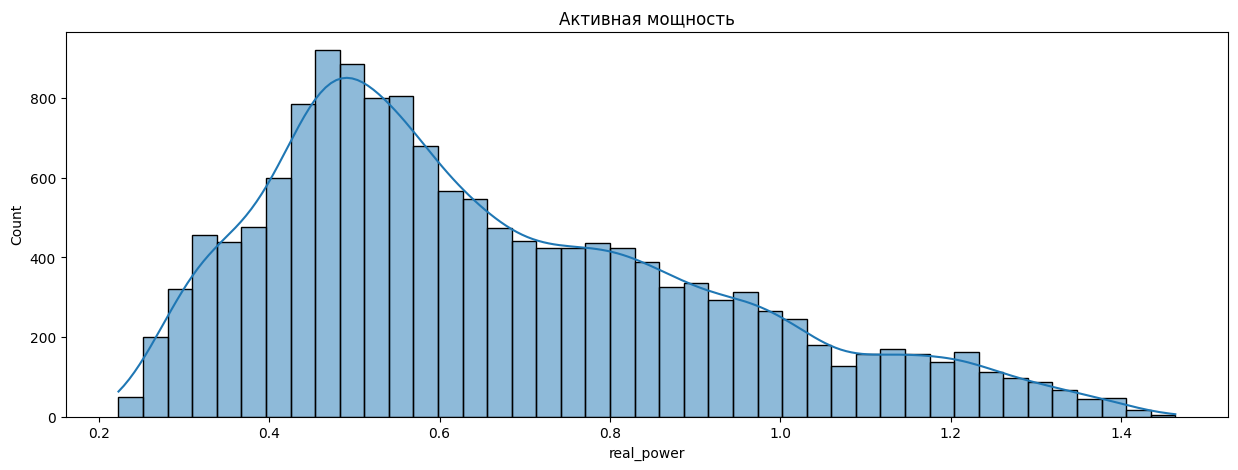

In [98]:
plt.figure(figsize = (15, 5))
sns.histplot(arc['real_power'], kde = True)
plt.title('Активная мощность');

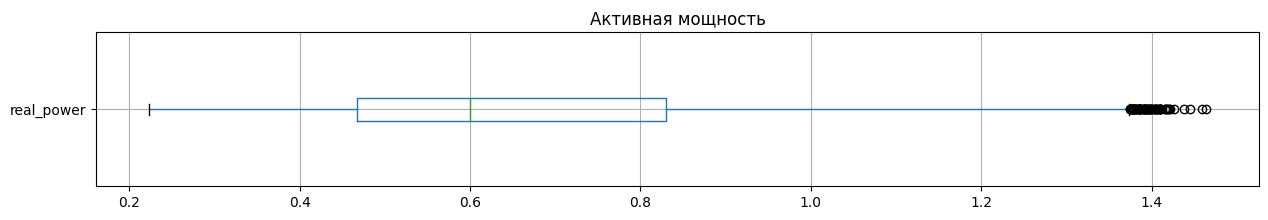

In [99]:
plt.figure(figsize = (15, 2))
arc.boxplot('real_power', vert = False)
plt.title('Активная мощность');

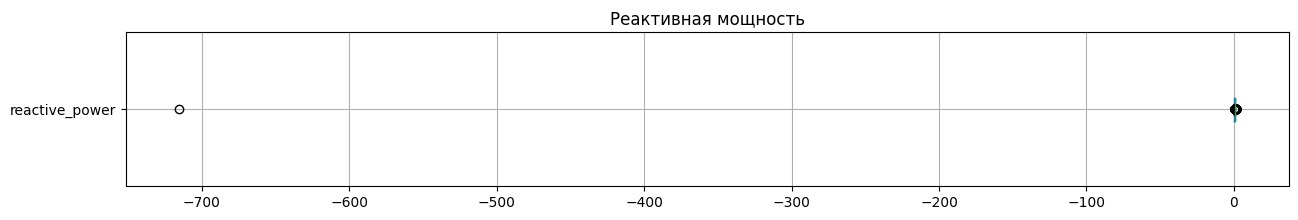

In [100]:
plt.figure(figsize = (15, 2))
arc.boxplot('reactive_power', vert = False)
plt.title('Реактивная мощность');

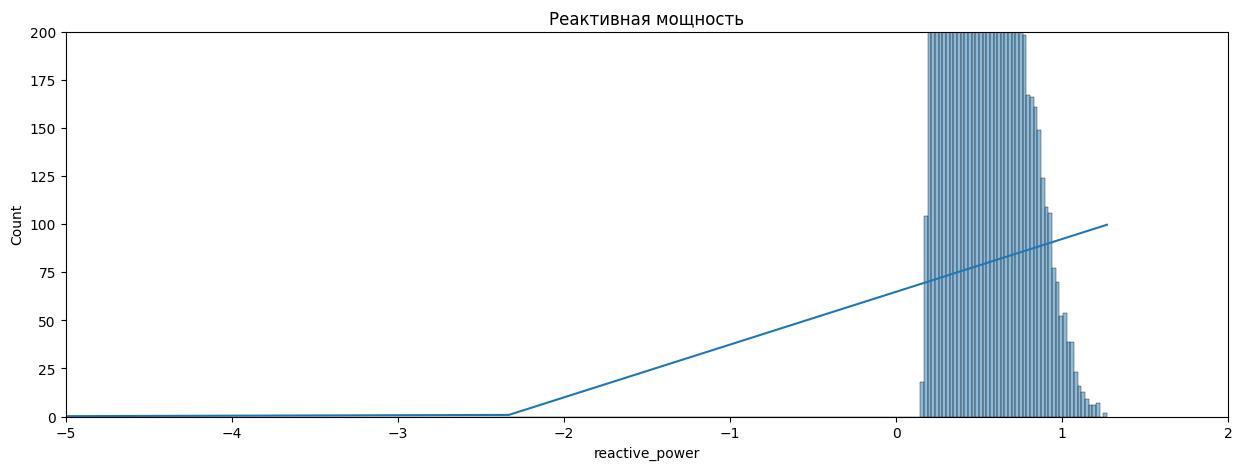

In [101]:
plt.figure(figsize=(15, 5))
plt.ylim(0, 200)
plt.xlim(-5, 2)
sns.histplot(arc['reactive_power'], kde = True)
plt.title('Реактивная мощность');

Большинство значений приходится на отрезок от 0 до 1.5, отрицательные значения по полученной информации некорректны, удалим

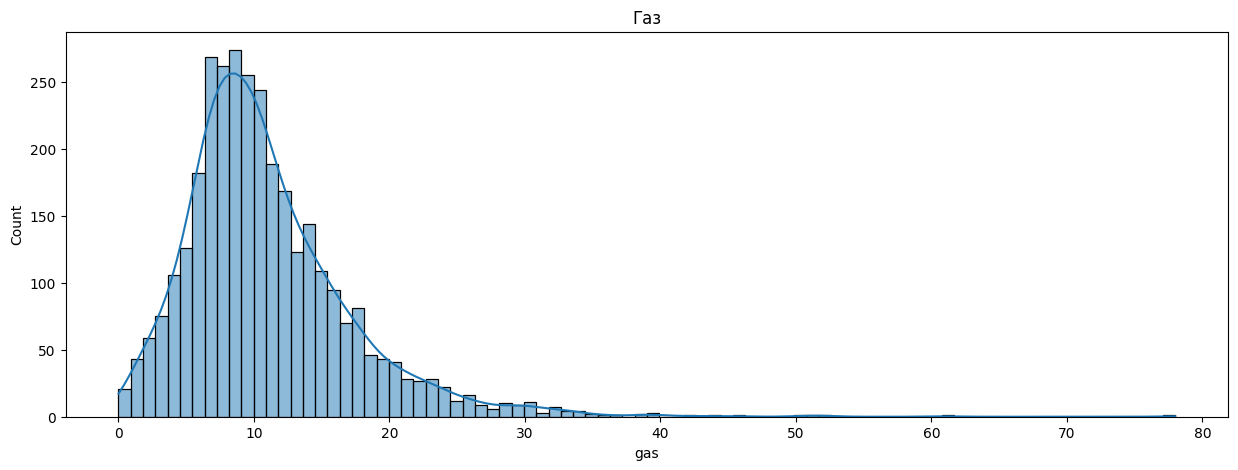

In [102]:
plt.figure(figsize = (15, 5))
sns.histplot(gas['gas'], kde = True)
plt.title('Газ');

Наибольшая плотность значений газа до 40, остальная информация может оказаться лишней при построении модели

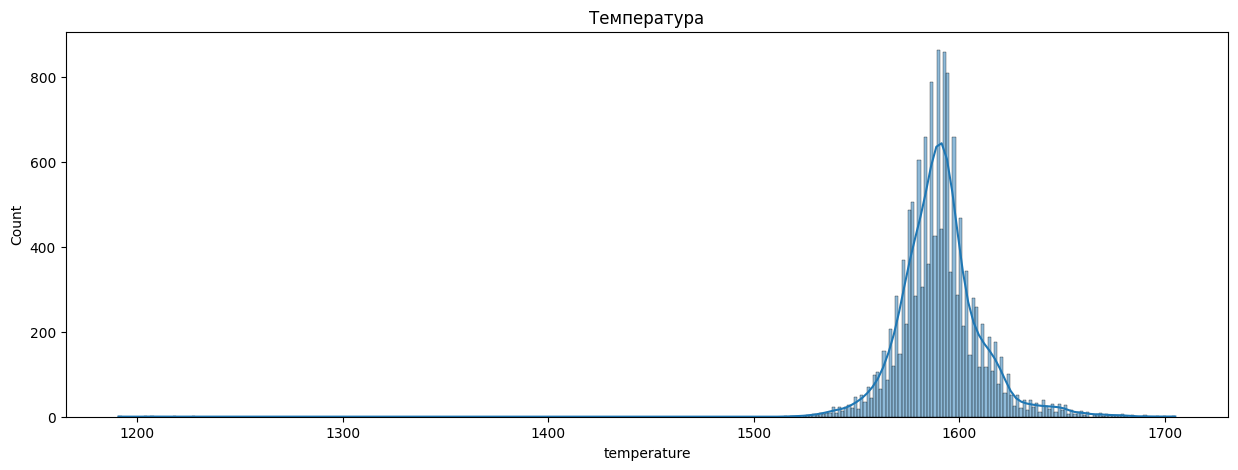

In [103]:
plt.figure(figsize = (15, 5))
sns.histplot(temp['temperature'], kde = True)
plt.title('Температура');

Отрицательные значения реактивной мощности для производства некорректны, удалим, точно так же как и температура плавления до 1400.

In [104]:
def boxplot(data):
    plt.figure(figsize = (15, 5))
    data.boxplot([col for col in data.columns if col != 'key']);

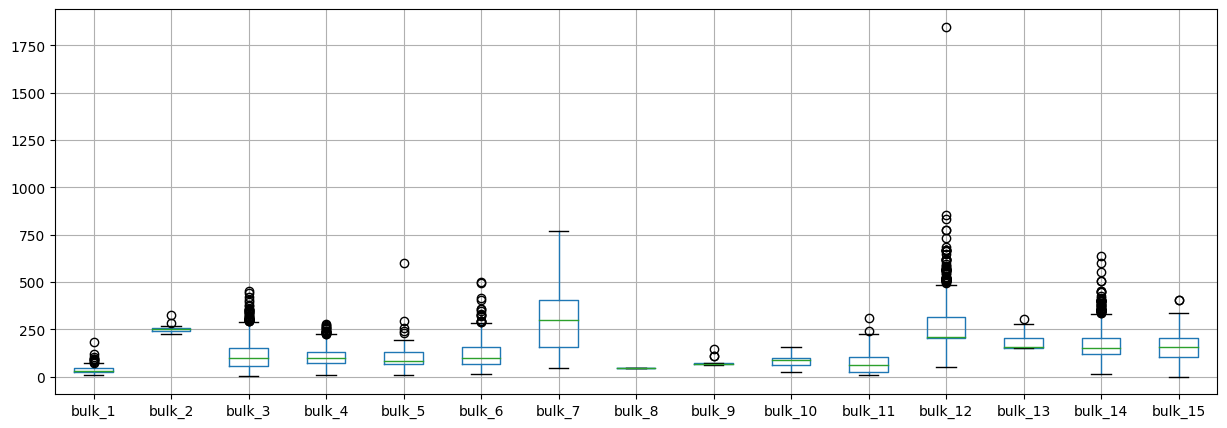

In [105]:
boxplot(bulk)

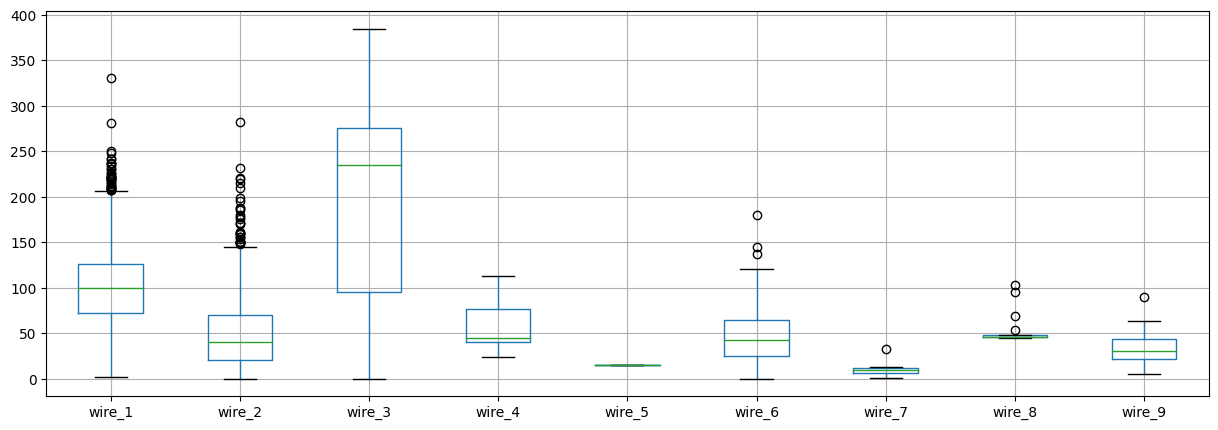

In [106]:
boxplot(wire)

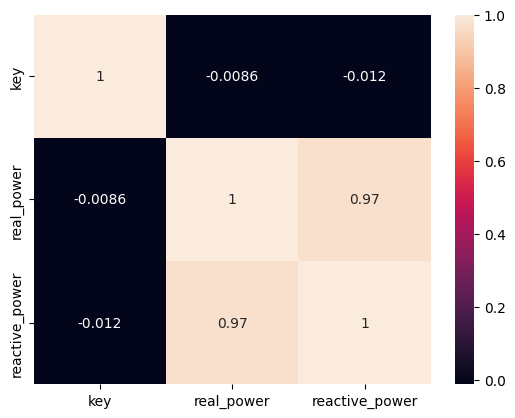

In [107]:
sns.heatmap(arc.corr(method = "spearman"), annot = True);

In [108]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   time         18092 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [109]:
key = temp[temp['temperature'] <= 1500]['key'].unique()
temp = temp[~temp['key'].isin(key)]
temp = temp.reset_index(drop=True)
temp.head()

,key,time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [110]:
temp['temp_time_start'] = temp.groupby(['key'])['time'].transform(min)
temp['temp_time_end'] = temp.groupby(['key'])['time'].transform(max)

In [111]:
temp['temp_seconds'] = temp['temp_time_end'] - temp['temp_time_start']
temp['temp_seconds']  = temp['temp_seconds'].apply(pd.Timedelta.total_seconds).astype('float')

In [112]:
temp = temp[(temp['temp_time_end'] == temp['time']) | (temp['temp_time_start'] == temp['time'])]

In [113]:
temp = temp[(temp['temp_time_end'] != temp['temp_time_start'])]

In [114]:
temp.head(10)

,key,time,temperature,temp_time_start,temp_time_end,temp_seconds
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:02:04,2019-05-03 11:30:38,1714.0
5,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,2019-05-03 11:30:38,1714.0
6,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:34:04,2019-05-03 11:55:09,1265.0
10,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,2019-05-03 11:55:09,1265.0
11,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:06:44,2019-05-03 12:35:57,1753.0
16,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,2019-05-03 12:35:57,1753.0
17,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:39:27,2019-05-03 12:59:47,1220.0
21,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,2019-05-03 12:59:47,1220.0
22,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:11:03,2019-05-03 13:36:39,1536.0
26,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,2019-05-03 13:36:39,1536.0


In [115]:
temp['temp_start'] = temp.groupby(['key'])['temperature'].transform(min)
temp['temp_end'] = temp.groupby(['key'])['temperature'].transform(max)

In [116]:
temp = temp[(temp['temp_end'] != temp['temp_start'])]

In [117]:
temp = temp.groupby('key').nth(0)

In [118]:
temp = temp.drop(axis = 1, columns = ['time', 'temperature', 'temp_time_start', 'temp_time_end'])

In [119]:
temp.head()

,temp_seconds,temp_start,temp_end
key,,,
1,1714.0,1571.0,1613.0
2,1265.0,1581.0,1602.0
3,1753.0,1596.0,1599.0
4,1220.0,1601.0,1625.0
5,1536.0,1576.0,1602.0


In [120]:
arc.head(10)

,key,start_heat,end_heat,real_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [121]:
arc['time_min'] = arc.groupby(['key'])['start_heat'].transform(min)
arc['time_max'] = arc.groupby(['key'])['end_heat'].transform(max)

In [122]:
arc['full_power'] = (arc['real_power']**2 + arc['reactive_power']**2)**(0.5)

In [123]:
arc['arc_seconds'] = arc['end_heat'] - arc['start_heat']
arc['arc_seconds']  = arc['arc_seconds'].apply(pd.Timedelta.total_seconds).astype('float')

In [124]:
arc['energy'] = arc['arc_seconds'] * arc['full_power']

In [125]:
arc = arc[arc.reactive_power > 0]

In [126]:
arc.head(15)

,key,start_heat,end_heat,real_power,reactive_power,time_min,time_max,full_power,arc_seconds,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,2019-05-03 11:02:14,2019-05-03 11:28:37,0.371123,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,2019-05-03 11:02:14,2019-05-03 11:28:37,0.902319,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2019-05-03 11:02:14,2019-05-03 11:28:37,0.722536,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,2019-05-03 11:02:14,2019-05-03 11:28:37,0.642824,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2019-05-03 11:02:14,2019-05-03 11:28:37,1.079934,148.0,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,2019-05-03 11:34:14,2019-05-03 11:53:18,0.440239,137.0,60.312695
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,2019-05-03 11:34:14,2019-05-03 11:53:18,0.332731,338.0,112.463079
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,2019-05-03 11:34:14,2019-05-03 11:53:18,0.860064,126.0,108.368056
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,2019-05-03 11:34:14,2019-05-03 11:53:18,0.955315,210.0,200.616176
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,2019-05-03 12:06:54,2019-05-03 12:32:19,1.373863,280.0,384.681584


In [127]:
new_arc = arc.groupby('key').sum()[['arc_seconds', 'full_power', 'energy']].reset_index()
new_arc.head()

,key,arc_seconds,full_power,energy
0,1,1098.0,3.718736,770.282114
1,2,811.0,2.588349,481.760005
2,3,655.0,5.019223,722.837668
3,4,741.0,3.400038,683.455597
4,5,869.0,2.816980,512.169934


In [128]:
full = temp.merge(new_arc, on = 'key', how = 'inner')

In [129]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2429 entries, 0 to 2428
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2429 non-null   int64  
 1   temp_seconds  2429 non-null   float64
 2   temp_start    2429 non-null   float64
 3   temp_end      2429 non-null   float64
 4   arc_seconds   2429 non-null   float64
 5   full_power    2429 non-null   float64
 6   energy        2429 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 151.8 KB


In [130]:
full_bulk = bulk.merge(bulk_time, on = 'key', how = 'inner')

In [131]:
full_wire = wire.merge(wire_time, on = 'key', how = 'inner')

In [132]:
full_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        3129 non-null   int64         
 1   bulk_1_x   252 non-null    float64       
 2   bulk_2_x   22 non-null     float64       
 3   bulk_3_x   1298 non-null   float64       
 4   bulk_4_x   1014 non-null   float64       
 5   bulk_5_x   77 non-null     float64       
 6   bulk_6_x   576 non-null    float64       
 7   bulk_7_x   25 non-null     float64       
 8   bulk_8_x   1 non-null      float64       
 9   bulk_9_x   19 non-null     float64       
 10  bulk_10_x  176 non-null    float64       
 11  bulk_11_x  177 non-null    float64       
 12  bulk_12_x  2450 non-null   float64       
 13  bulk_13_x  18 non-null     float64       
 14  bulk_14_x  2806 non-null   float64       
 15  bulk_15_x  2248 non-null   float64       
 16  bulk_1_y   252 non-null    datetime64[ns]


In [133]:
full_bulk = full_bulk.drop(axis = 1, columns = ['bulk_2_x', 'bulk_5_x', 'bulk_7_x', 'bulk_8_x',
                                                'bulk_9_x', 'bulk_13_x', 'bulk_2_y', 'bulk_5_y', 'bulk_7_y', 'bulk_8_y', 'bulk_9_y', 'bulk_13_y'])

In [134]:
full_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       3081 non-null   int64         
 1   wire_1_x  3055 non-null   float64       
 2   wire_2_x  1079 non-null   float64       
 3   wire_3_x  63 non-null     float64       
 4   wire_4_x  14 non-null     float64       
 5   wire_5_x  1 non-null      float64       
 6   wire_6_x  73 non-null     float64       
 7   wire_7_x  11 non-null     float64       
 8   wire_8_x  19 non-null     float64       
 9   wire_9_x  29 non-null     float64       
 10  wire_1_y  3055 non-null   datetime64[ns]
 11  wire_2_y  1079 non-null   datetime64[ns]
 12  wire_3_y  63 non-null     datetime64[ns]
 13  wire_4_y  14 non-null     datetime64[ns]
 14  wire_5_y  1 non-null      datetime64[ns]
 15  wire_6_y  73 non-null     datetime64[ns]
 16  wire_7_y  11 non-null     datetime64[ns]
 17  wire_8_y  19 n

In [135]:
full_wire = full_wire.drop(axis = 1, columns = ['wire_3_x', 'wire_4_x', 'wire_5_x', 'wire_6_x',
                                                'wire_7_x', 'wire_8_x', 'wire_9_x', 'wire_3_y', 'wire_4_y', 'wire_5_y', 'wire_6_y', 'wire_7_y', 'wire_8_y', 'wire_9_y'])

In [136]:
full_bulk = full_bulk.fillna(0)

In [137]:
full_wire = full_wire.fillna(0)

In [138]:
full = full.merge(full_bulk, on = 'key', how = 'inner')

In [139]:
full = full.merge(full_wire, on = 'key', how = 'inner')

In [140]:
full = full.merge(gas, on = 'key', how = 'inner')

In [141]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 0 to 2288
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2289 non-null   int64  
 1   temp_seconds  2289 non-null   float64
 2   temp_start    2289 non-null   float64
 3   temp_end      2289 non-null   float64
 4   arc_seconds   2289 non-null   float64
 5   full_power    2289 non-null   float64
 6   energy        2289 non-null   float64
 7   bulk_1_x      2289 non-null   float64
 8   bulk_3_x      2289 non-null   float64
 9   bulk_4_x      2289 non-null   float64
 10  bulk_6_x      2289 non-null   float64
 11  bulk_10_x     2289 non-null   float64
 12  bulk_11_x     2289 non-null   float64
 13  bulk_12_x     2289 non-null   float64
 14  bulk_14_x     2289 non-null   float64
 15  bulk_15_x     2289 non-null   float64
 16  bulk_1_y      2289 non-null   object 
 17  bulk_3_y      2289 non-null   object 
 18  bulk_4_y      2289 non-null 

In [142]:
full = full.drop(axis = 1, columns = ['key'])

In [143]:
full = full.drop(axis = 1, columns = ['bulk_1_y', 'bulk_3_y', 'bulk_4_y', 'bulk_6_y', 'bulk_10_y', 'bulk_11_y', 'bulk_12_y', 'bulk_14_y', 'bulk_15_y', 'wire_1_y', 'wire_2_y'])

In [144]:
full.reset_index(drop = True, inplace = True)

In [145]:
full = full[full.gas < 45]

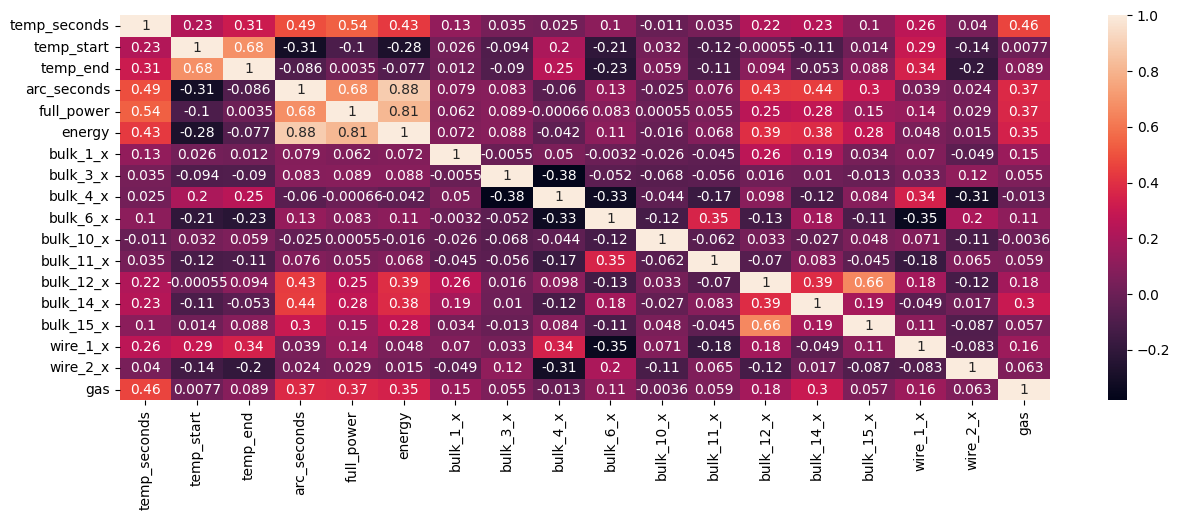

In [146]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.heatmap(full.corr(method = "spearman"), annot = True);

Небольшая мельтиколлинеарность есть только между значениями сыпучих и проволочных материалов и температурами

#Построение модели

In [147]:
features = full.drop(['temp_end'], axis=1)
target = full['temp_end']

In [148]:
features.head()

,temp_seconds,temp_start,arc_seconds,full_power,energy,bulk_1_x,bulk_3_x,bulk_4_x,bulk_6_x,bulk_10_x,bulk_11_x,bulk_12_x,bulk_14_x,bulk_15_x,wire_1_x,wire_2_x,gas
0,1714.0,1571.0,1098.0,3.718736,770.282114,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986
1,1265.0,1581.0,811.0,2.588349,481.760005,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561
2,1753.0,1596.0,655.0,5.019223,722.837668,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793
3,1220.0,1601.0,741.0,3.400038,683.455597,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219
4,1536.0,1576.0,869.0,2.816980,512.169934,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692


In [149]:
features = features.drop(axis = 1, columns = ['bulk_1_x', 'bulk_3_x', 'bulk_4_x', 'bulk_6_x', 'bulk_10_x', 'bulk_11_x'])

In [150]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [151]:
print(full.shape)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(2284, 18)
(1713, 11)
(1713,)
(571, 11)
(571,)


##Подбор гиперпараметров

In [159]:
%%time
line_model = LinearRegression()
score = cross_val_score(line_model, features_train, target_train, scoring=  'neg_mean_absolute_error', cv = 5)
print('MAE:', -score)

MAE: [9.22073579 9.01372217 8.55163024 8.68195006 8.79301241]
CPU times: user 46.9 ms, sys: 29 ms, total: 75.9 ms
Wall time: 42.3 ms


In [160]:
%%time
forest_model = RandomForestRegressor(random_state = RANDOM_STATE)
parametrs = {'max_depth' : range(2, 12, 2),
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_estimators' : range(40, 261, 20)}
grid = GridSearchCV(forest_model, parametrs, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
grid.fit(features_train, target_train)
best_score = grid.best_score_
print(grid.best_estimator_)
print('MAE: ', -grid.best_score_)

RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=260,
                      random_state=240423)
MAE:  7.378760633436755
CPU times: user 9.78 s, sys: 928 ms, total: 10.7 s
Wall time: 7min 29s


In [161]:
%%time
cat_model = CatBoostRegressor(random_seed = RANDOM_STATE, verbose = 1)

params = {'learning_rate': [0.01, 0.1, 0.5, 1, 2],
        'iterations': [20, 40, 60],
        'depth': [3, 4, 5, 6, 7, 8, 9, 10],
        }
cat_cv = GridSearchCV(cat_model, params, scoring = 'neg_mean_absolute_error', n_jobs = -1, cv = 5, verbose = 1)

cat_cv.fit(features_train, target_train)

print(cat_cv.best_params_)
print('MAE:', -cat_cv.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
0:	learn: 13.1183547	total: 47.6ms	remaining: 1.86s
1:	learn: 11.6447826	total: 48.9ms	remaining: 930ms
2:	learn: 11.0413307	total: 50.4ms	remaining: 622ms
3:	learn: 10.5523452	total: 51.6ms	remaining: 465ms
4:	learn: 10.3198224	total: 53ms	remaining: 371ms
5:	learn: 10.0061828	total: 54.5ms	remaining: 309ms
6:	learn: 9.8555517	total: 55.8ms	remaining: 263ms
7:	learn: 9.7307317	total: 57.2ms	remaining: 229ms
8:	learn: 9.6136453	total: 58.5ms	remaining: 202ms
9:	learn: 9.5137748	total: 59.9ms	remaining: 180ms
10:	learn: 9.4266590	total: 61.3ms	remaining: 162ms
11:	learn: 9.3424706	total: 62.8ms	remaining: 146ms
12:	learn: 9.3021479	total: 64.2ms	remaining: 133ms
13:	learn: 9.2541292	total: 65.4ms	remaining: 122ms
14:	learn: 9.1434732	total: 66.8ms	remaining: 111ms
15:	learn: 9.0908275	total: 68.2ms	remaining: 102ms
16:	learn: 9.0097973	total: 69.7ms	remaining: 94.3ms
17:	learn: 8.9377676	total: 71ms	remaining: 86.8ms
18:	lea

In [162]:
%%time
light_model = LGBMRegressor(random_state = RANDOM_STATE, boosting_type = 'gbdt', objective = 'regression')
light_params = {'n_estimators': [10, 25, 50, 75, 100],
               'max_depth': [5, 10, 15, 25, 30],
               'num_leaves': [10, 20, 31],
               'learning_rate': [0.01, 0.1, 0.15]}
light_cv = GridSearchCV(light_model,
                             light_params,
                             cv = 5,
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             verbose = 1,
                             error_score = 'raise')

light_cv.fit(features_train, target_train)

print(light_cv.best_params_)
print('MAE:', -light_cv.best_score_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 1713, number of used features: 11
[LightGBM] [Info] Start training from score 1600.299475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [163]:
%%time
xb = XGBRegressor(booster = 'gbtree', use_rmm = True, verbosity = 0)
xb_params = {'n_estimators': [10, 25, 50, 75, 100],
               'max_depth': [5, 10, 15, 25, 30],
               'num_leaves': [10, 20, 31],
               'learning_rate': [0.01, 0.1, 0.15]}
xb_cv = GridSearchCV(xb,
                     xb_params,
                     cv = 5,
                     scoring = 'neg_mean_absolute_error',
                     n_jobs = -1,
                     verbose = 1,
                     error_score = 'raise')

xb_cv.fit(features_train, target_train)

print(xb_cv.best_params_)
print('MAE:', -xb_cv.best_score_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 10}
MAE: 7.387487020624745
CPU times: user 4.95 s, sys: 392 ms, total: 5.35 s
Wall time: 3min 11s


In [164]:
%%time
l1_ratios = np.linspace(0, 1, 11, endpoint = True)
alphas = np.linspace(0.1, 1, 10, endpoint = True)
param_grid = {'l1_ratio': l1_ratios,
              'alpha': alphas
             }
en_r = ElasticNet(random_state = RANDOM_STATE)

grid_search_r = GridSearchCV(estimator = en_r,
                           param_grid = param_grid,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 2,
                           scoring = 'neg_mean_absolute_error')
grid_search_r.fit(features_train, target_train)

print(grid_search_r.best_params_)
print('MAE:', -grid_search_r.best_score_)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
{'alpha': 0.1, 'l1_ratio': 1.0}
MAE: 8.855041046552495
CPU times: user 385 ms, sys: 21.8 ms, total: 407 ms
Wall time: 3.43 s


In [165]:
%%time
knn = KNeighborsRegressor()
params = { 'n_neighbors' : [3, 5, 7, 9, 11, 13],
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2]}
clf = GridSearchCV(estimator = knn,
                   param_grid = params,
                   cv = 5,
                   scoring = 'neg_mean_absolute_error',
                   verbose = 1)

clf.fit(features_train, target_train)

print(clf.best_estimator_)
print(clf.best_params_)
print('MAE:', -clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNeighborsRegressor(n_neighbors=11, p=1, weights='distance')
{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
MAE: 9.777188030204318
CPU times: user 1.23 s, sys: 88.3 ms, total: 1.31 s
Wall time: 1.22 s


Наилучшей моделью оказался случайный лес, рассмотрим позже на тестовой выборке. Пока, без экономических расчетов, трудно сказать будет ли разница в 6 градусов влиять на расходы

##Тестирование модели

In [166]:
light_model = LGBMRegressor(random_state = RANDOM_STATE, boosting_type = 'gbdt', objective = 'regression', learning_rate = 0.1, max_depth = 5, n_estimators = 100, num_leaves = 20)
light_model.fit(features_train, target_train)
predictions = light_model.predict(features_test)
print('MAE:', mean_absolute_error(target_test, predictions))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 1713, number of used features: 11
[LightGBM] [Info] Start training from score 1600.299475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

На тестовых данных модель дала чуть более хороший результат (разница между целевым и предсказнным значениями 6,7 градусов)

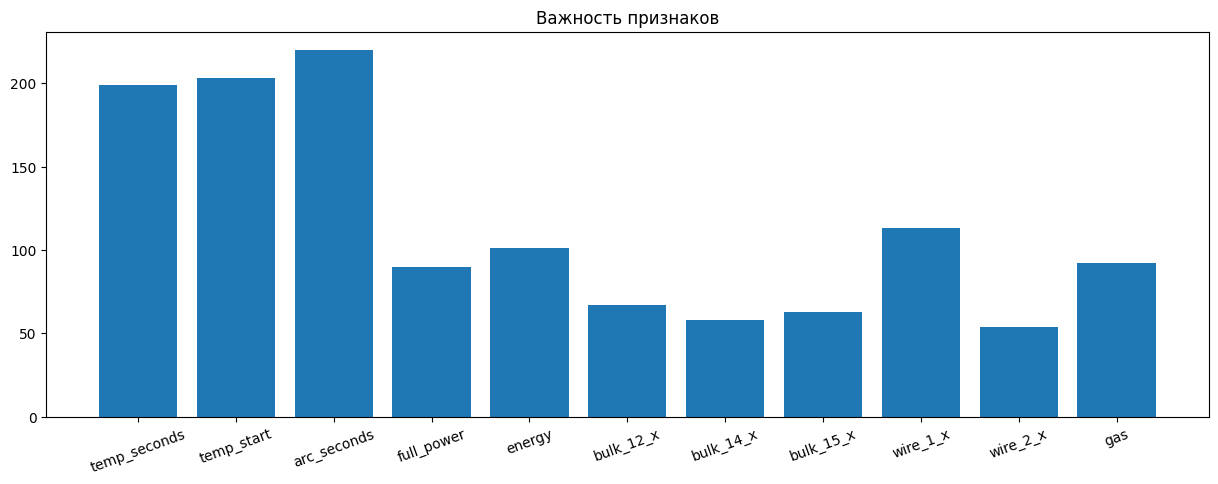

In [167]:
plt.figure(figsize = (15, 5))
plt.bar(features_test.columns, light_model.feature_importances_)
plt.xticks(rotation = 20)
plt.title("Важность признаков");

Самыми важными признаками окаазалась начальная температура и общее время нарева для каждой итерации

#Вывод

1. План

Изучили сырые данные;

Рассмотрели на графиках распределения температуры и мощности, удалили некорректные значения температур, газа, мощностей, заполнили пропуски реагентов(bulk, wire);

Создали общую выборку для работы по партиям(ключам);

Подобрали лчушую модель и протестировали ее.

2. Трудности

Присутствуют партии без температуры, некорректные партии где начало и конец нагрева одинаковы. есть партии совсем без добавок.

3. Ключевые шаги

Расчитали полную мощность(так как реактивная мощность практически не используется в производстве), энергию(работу) для каждой партии;

Убрали партии где температура была ниже 1500 градусов как некорректные(по температуре плавки стали) и где время изменения температуры со временам нагрева были одинаковы(то есть партии которые прошли за 0.1 сек);

Добавили в общую таблицу толко те данные, которые есть везде, то есть все совпадающие корректные партии;

Избавились от признаков которые мало использовались при производстве(реагенты), если на 3000 партий приходилось всего лишь 22 попытки добавки этого материала.

По общим верным данным подобрали модели и протестировали лучшую.

4. Итоговая модель

Наилучшей моделью оказалась оказалась LGBM с метрикой MAE 6.79(разница между целевым и предсказанным значением 6.79 градуса) с параметрами:
random_state = 240423(по условию задачи), со стандартным бустингом gbdt дерева решений(boosting_type = 'gbdt'), с целевой функией регрессии(objective = 'regression'), со скоростью обучения 0.1(learning_rate = 0.1), с глубиной дерева равной 5(max_depth = 5), с максимальным количеством листьев/решений 20(num_leaves = 20) и количеством деревьев 100(n_estimators = 100)

5. Рекомендации

Так как по данным температура при производстве одной партии не только росла, но и снижалась, попробовать производить партию от начала до конца нагревая лишь один раз. Наверное, постоянные скачки электричества при нагреве(большая мощность и износ материалов) должны быть дороже, чем постепенное повышение.

Стоит обратить внимание на последовательность производства, так как были партии которые начинались верно, но отсутствовало следующее добавление материалов или продувка газом, то есть партия обрывалась посередние, так же есть партии прошедшие за 0.001 секунд, то есть тоже некорректные. Возможно, где-то на производстве данные собираются с ошибкой, можно проверить оборудование или БД.

Самыми важными признками для модели оказались время наргева и время изменения температуры, а так же начальная температура при производстве партии, можно обратить внимание на время необходимое для создания одной партии(выше про постепенный нагрев без скачков). Возможно, стоит добавить больше информации по самим реагентам, так как разные примеси требуют разных температур для смешивания, одно только время добавки слабо помогает